In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE

# Load dataset
df = pd.read_csv("Data/lc_loan.csv")  

In [118]:
df.head()

,id,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,year,early_default,return
0,1077501,5000.0,5000.0,0.1065,162.87,B,B2,10+ years,RENT,24000.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,0,0.172631
1,1077175,2400.0,2400.0,0.1596,84.33,C,C5,10+ years,RENT,12252.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,0,0.252361
2,1076863,10000.0,10000.0,0.1349,339.31,C,C1,10+ years,RENT,49200.0,...,37.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,0,0.223189
3,1075269,5000.0,5000.0,0.0790,156.46,A,A4,3 years,RENT,36000.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,0,0.126442
4,1072053,3000.0,3000.0,0.1864,109.43,E,E1,9 years,RENT,48000.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,0,0.313045


In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

Numeric columns:
['id', 'loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'year', 'early_default', 'return']

Categorical columns:
['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line']

Categorical Columns Analysis:

grade value counts:
grade
B    323590
C    251217
A    208644
D    111319
E     30867
Name: count, dtype: int64

sub_grade value counts:
sub_grade
B5    68403
B3    67015
B4    66680
C1    64437
B2    62446
Name: count, dtype: int64

emp_length value counts:
emp_length
10+ years    294578
2 years       86249
3 years       76231
< 1 year      75356
1 year       

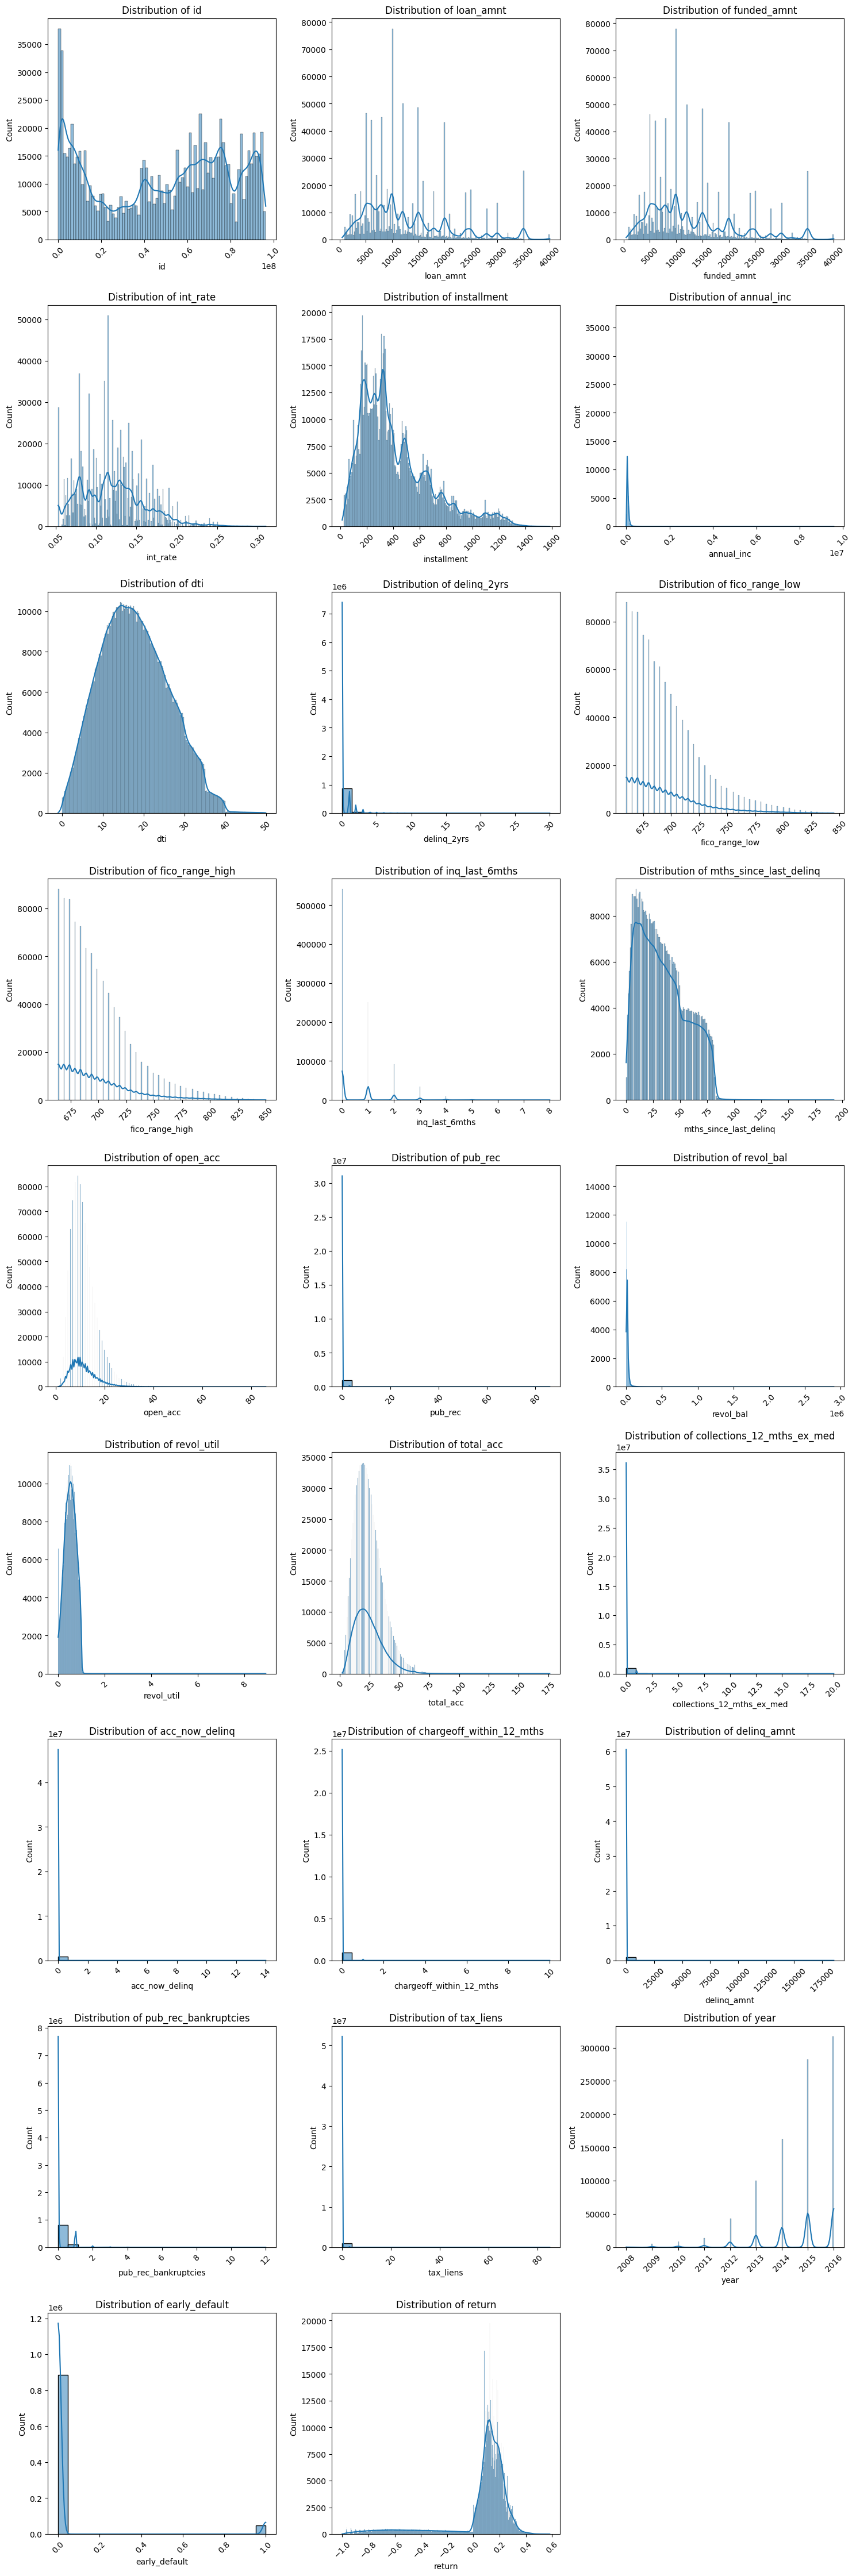


Unique values in columns to be encoded:

grade:
grade
B    323590
C    251217
A    208644
D    111319
E     30867
F      6500
G      1023
Name: count, dtype: int64

sub_grade:
sub_grade
B5    68403
B3    67015
B4    66680
C1    64437
B2    62446
B1    59046
C2    55796
A5    54609
C3    48395
A4    47020
C4    44155
A1    41429
C5    38434
A3    32918
A2    32668
D1    32452
D2    26351
D3    21648
D4    17463
D5    13405
E1     9861
E2     7844
E3     5777
E4     4084
E5     3301
F1     2323
F2     1384
F3     1320
F4      868
F5      605
G1      380
G2      279
G3      161
G4      116
G5       87
Name: count, dtype: int64

emp_length:
emp_length
10+ years    294578
2 years       86249
3 years       76231
< 1 year      75356
1 year        63281
5 years       58757
4 years       56383
6 years       43770
8 years       43533
7 years       40942
9 years       35312
Name: count, dtype: int64

verification_status:
verification_status
Source Verified    355725
Not Verified       302971
Ver

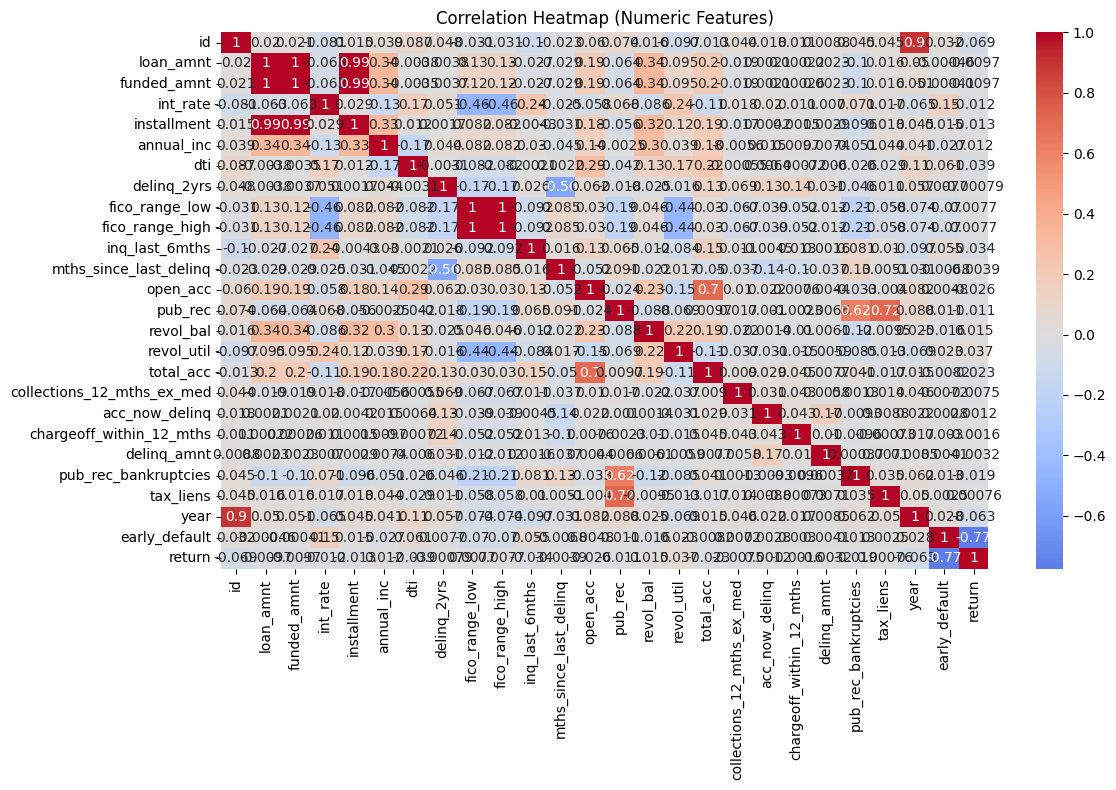


Target Variable (return) Statistics:
count    933160.000000
mean          0.065197
std           0.247727
min          -1.000000
25%           0.073529
50%           0.127677
75%           0.188737
max           0.581820
Name: return, dtype: float64


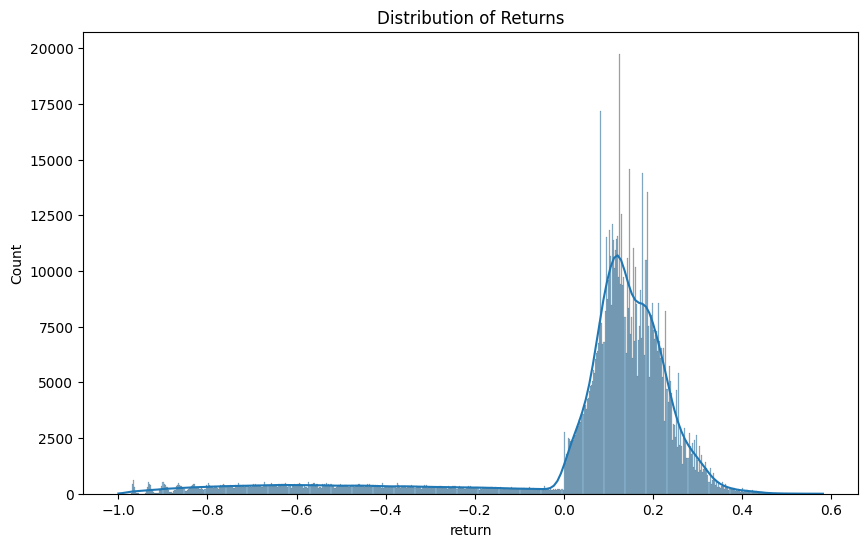

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numeric columns:")
print(numeric_cols.tolist())
print("\nCategorical columns:")
print(categorical_cols.tolist())

print("\nCategorical Columns Analysis:")
for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts().head())

print("\nNumeric Columns Statistics:")
print(df[numeric_cols].describe())

print("\nMissing Values:")
print(df.isnull().sum())

plt.figure(figsize=(15, 5*((len(numeric_cols)-1)//3 + 1)))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols)-1)//3 + 1, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

label_encode_features = [
    'grade',        
    'sub_grade',    
    'emp_length',   
    'verification_status'  
]

onehot_encode_features = [
    'home_ownership',    
    'purpose',          
    'addr_state',       
    'loan_status',      
]

print("\nUnique values in columns to be encoded:")
for col in label_encode_features + onehot_encode_features:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts())

numeric_corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()

if 'return' in df.columns:
    print("\nTarget Variable (return) Statistics:")
    print(df['return'].describe())
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['return'], kde=True)
    plt.title('Distribution of Returns')
    plt.show()

In [121]:
# Financial ratios
df['debt_to_income'] = df['loan_amnt'] / df['annual_inc']
df['payment_to_income'] = df['installment'] / (df['annual_inc'] / 12)
df['loan_to_value'] = df['loan_amnt'] / df['funded_amnt']

# Interest rate related
df['interest_income'] = df['loan_amnt'] * df['int_rate']
df['effective_rate'] = df['installment'] * 12 / df['loan_amnt'] - 1

In [122]:
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade_numeric'] = df['grade'].map(grade_mapping)
df = df.drop('grade', axis=1)



In [123]:
# Create interaction terms for highly correlated features
df['loan_income_interaction'] = df['loan_amnt'] * np.log1p(df['annual_inc'])
df['dti_grade_interaction'] = df['dti'] * df['grade_numeric']


In [124]:
skewed_features = ['annual_inc', 'loan_amnt', 'installment']
for feature in skewed_features:
    df[f'{feature}_log'] = np.log1p(df[feature])

In [125]:
# Bin continuous variables that might have non-linear relationships
df['dti_bins'] = pd.qcut(df['dti'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
df['income_bins'] = pd.qcut(df['annual_inc'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

Correlations with return for new features:
return                   1.000000
payment_buffer           0.036719
interest_income_ratio   -0.042051
risk_score              -0.045017
payment_income_grade    -0.048702
debt_burden_score       -0.049736
Name: return, dtype: float64


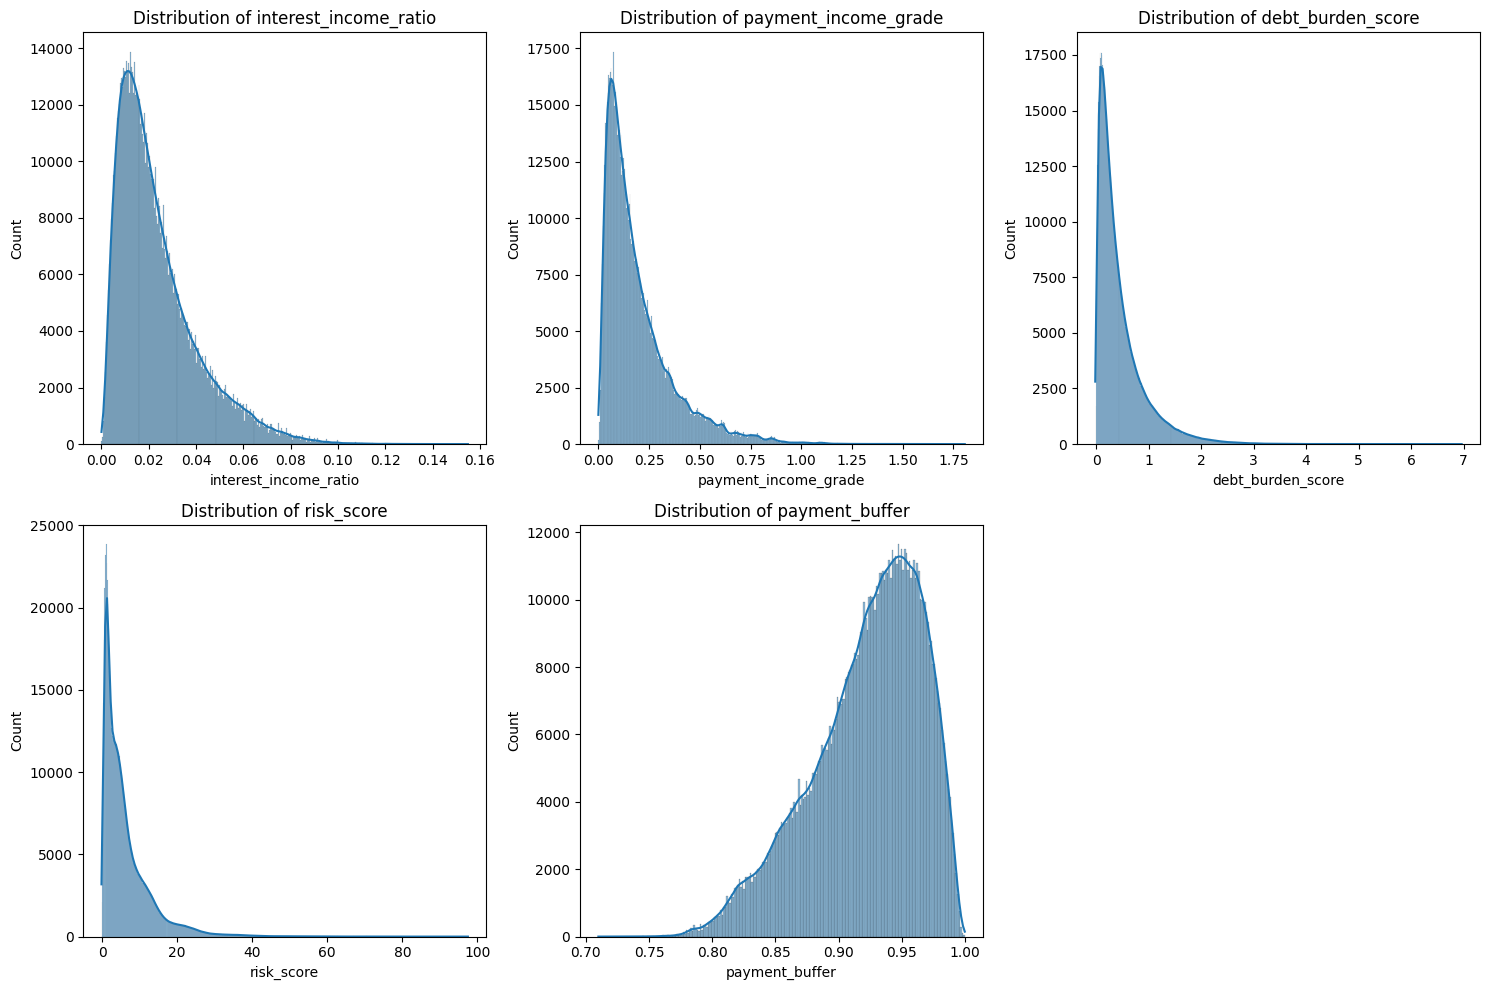


Top 15 features by correlation with return:
                                     feature  correlation  abs_correlation
return                                return     1.000000         1.000000
early_default                  early_default    -0.774694         0.774694
id                                        id    -0.069316         0.069316
year                                    year    -0.063327         0.063327
debt_burden_score          debt_burden_score    -0.049736         0.049736
payment_income_grade    payment_income_grade    -0.048702         0.048702
dti_grade_interaction  dti_grade_interaction    -0.046712         0.046712
risk_score                        risk_score    -0.045017         0.045017
interest_income_ratio  interest_income_ratio    -0.042051         0.042051
dti                                      dti    -0.039181         0.039181
revol_util                        revol_util     0.036785         0.036785
payment_buffer                payment_buffer     0.0367

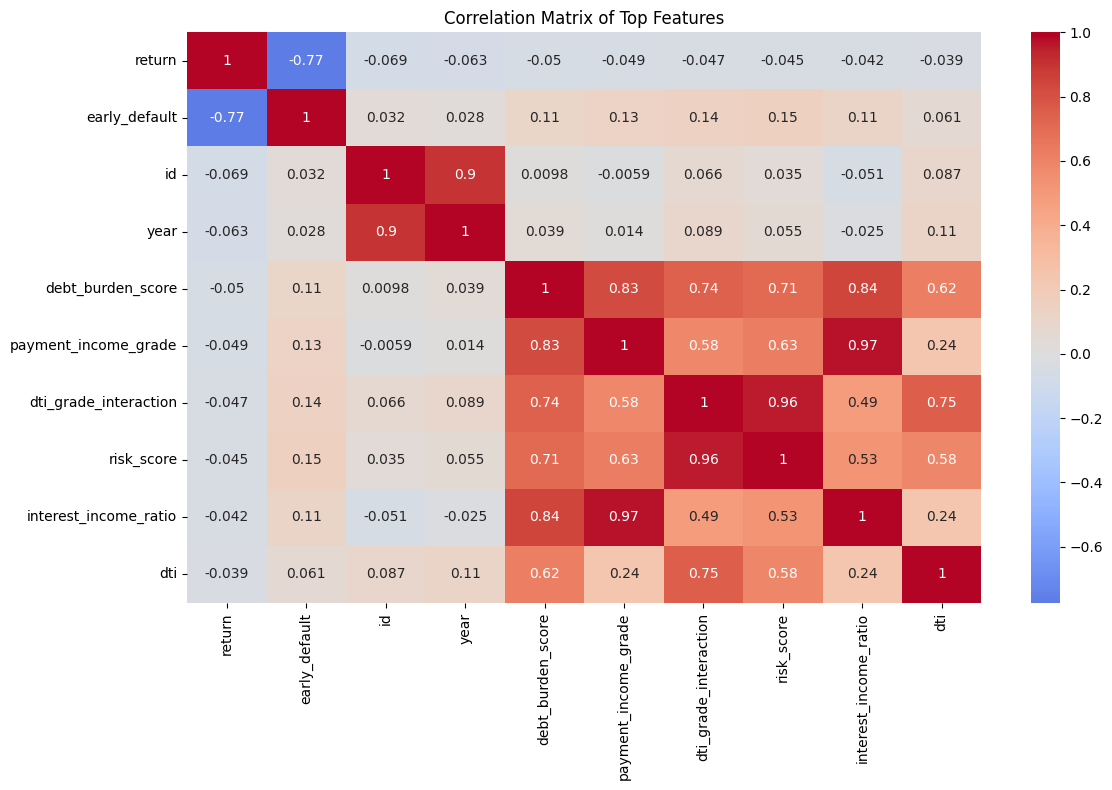


VIF for top features:
                 Feature        VIF
6  dti_grade_interaction  38.234897
8  interest_income_ratio  30.076257
5   payment_income_grade  29.435466
7             risk_score  22.758384
3                   year  19.106490
4      debt_burden_score  10.439304
9                    dti   7.552725
2                     id   3.732934
1          early_default   2.617188
0                 return   2.565079


In [ ]:
df['interest_income_ratio'] = df['interest_income'] / df['annual_inc']
df['payment_income_grade'] = df['payment_to_income'] * df['grade_numeric']
df['debt_burden_score'] = df['dti'] * df['interest_income_ratio']

df['risk_score'] = df['grade_numeric'] * df['int_rate'] * df['dti']
df['payment_buffer'] = 1 - (df['installment'] / (df['annual_inc'] / 12))

new_features = [
    'interest_income_ratio',
    'payment_income_grade',
    'debt_burden_score',
    'risk_score',
    'payment_buffer'
]

correlations = df[new_features + ['return']].corr()['return'].sort_values(ascending=False)
print("Correlations with return for new features:")
print(correlations)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(new_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

feature_importance = pd.DataFrame({
    'feature': df.select_dtypes(include=['float64', 'int64']).columns,
    'correlation': df.select_dtypes(include=['float64', 'int64']).corr()['return']
})
feature_importance['abs_correlation'] = abs(feature_importance['correlation'])
feature_importance = feature_importance.sort_values('abs_correlation', ascending=False)

print("\nTop 15 features by correlation with return:")
print(feature_importance.head(15))

top_features = feature_importance['feature'].head(10).tolist()
plt.figure(figsize=(12, 8))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i)
                       for i in range(df[features].shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\nVIF for top features:")
print(calculate_vif(df, top_features))

In [127]:
num_features = df.select_dtypes(include=['float64', 'int64']).columns
# num_features = num_features.drop(['return', 'loan_status'])
print(num_features)

Index(['id', 'loan_amnt', 'funded_amnt', 'int_rate', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'year', 'early_default', 'return',
       'debt_to_income', 'payment_to_income', 'loan_to_value',
       'interest_income', 'effective_rate', 'grade_numeric',
       'loan_income_interaction', 'dti_grade_interaction', 'annual_inc_log',
       'loan_amnt_log', 'installment_log', 'interest_income_ratio',
       'payment_income_grade', 'debt_burden_score', 'risk_score',
       'payment_buffer'],
      dtype='object')


In [128]:
cat_features = df.select_dtypes(include=['object']).columns
print(cat_features)


Index(['sub_grade', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line'],
      dtype='object')


In [129]:
df = df.drop('sub_grade', axis=1)

In [130]:
df[['emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line']].head()

,emp_length,home_ownership,verification_status,issue_d,purpose,zip_code,addr_state,earliest_cr_line
0,10+ years,RENT,Verified,Dec-2011,credit_card,860xx,AZ,Jan-1985
1,10+ years,RENT,Not Verified,Dec-2011,small_business,606xx,IL,Nov-2001
2,10+ years,RENT,Source Verified,Dec-2011,other,917xx,CA,Feb-1996
3,3 years,RENT,Source Verified,Dec-2011,wedding,852xx,AZ,Nov-2004
4,9 years,RENT,Source Verified,Dec-2011,car,900xx,CA,Jan-2007


In [131]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("\nMissing Values:\n", missing_values)


Missing Values:
 emp_length                 58768
mths_since_last_delinq    464293
dtype: int64



Delinquency Category Distribution:
delinq_category
No Delinquency    465283
36+ months        194118
12-24 months       98208
24-36 months       85536
6-9 months         26861
9-12 months        26068
3-6 months         23185
<3 months          13901
Name: count, dtype: int64


/var/folders/mn/p97zg4190kl_grdrb5c91h7m0000gn/T/ipykernel_22189/17657539.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['mths_since_last_delinq'].fillna(-1, inplace=True)


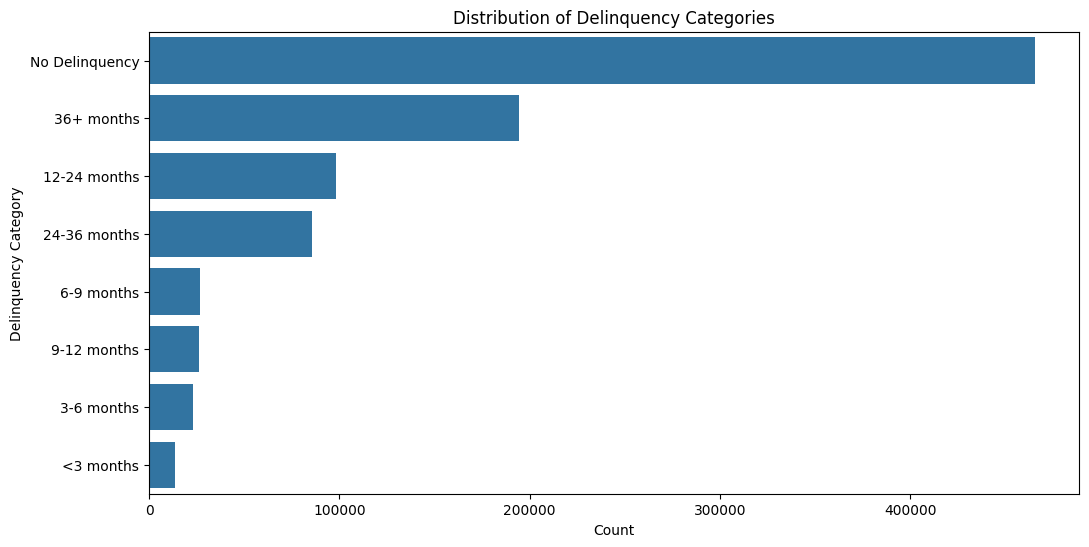

In [132]:
df['mths_since_last_delinq'].fillna(-1, inplace=True)

df['delinq_category'] = pd.cut(df['mths_since_last_delinq'], 
                                bins=[-float('inf'), 0, 3, 6, 9, 12, 24, 36, float('inf')],
                                labels=['No Delinquency', '<3 months', '3-6 months', '6-9 months', 
                                        '9-12 months', '12-24 months', '24-36 months', '36+ months'])

print("\nDelinquency Category Distribution:")
print(df['delinq_category'].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(y=df['delinq_category'], order=df['delinq_category'].value_counts().index)
plt.title('Distribution of Delinquency Categories')
plt.xlabel('Count')
plt.ylabel('Delinquency Category')
plt.show()

In [133]:
df[['mths_since_last_delinq', 'delinq_category']].head()
df = df.drop('mths_since_last_delinq', axis=1)

In [134]:
df['debt_to_income_squared'] = df['debt_to_income'] ** 2

In [135]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y")  # "Dec-2011" → datetime(2011, 12, 1)

df["issue_year"] = df["issue_d"].dt.year
df["issue_month"] = df["issue_d"].dt.month

df["months_since_first_issue"] = (df["issue_d"] - df["issue_d"].min()).dt.days // 30


In [136]:
df["zip_prefix"] = df["zip_code"].str[:3].astype(int)  
df.drop("zip_code", axis=1, inplace=True)  

df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y")  # Convert to datetime

df["credit_history_length"] = (df["issue_d"] - df["earliest_cr_line"]).dt.days // 365


In [137]:
if "emp_length" in df.columns:
    df["emp_length"] = df["emp_length"].astype(str)  # Convert to string first
    df["emp_length"] = df["emp_length"].fillna("Unknown")  # Fill NaNs
    df["emp_length"] = pd.Categorical(df["emp_length"], categories=['Unknown', '< 1 year', '1 year', '2 years', '3 years', 
                                                          '4 years', '5 years', '6 years', '7 years', '8 years', 
                                                          '9 years', '10+ years'], ordered=True)  # Convert back to ordered category


In [138]:
from sklearn.preprocessing import LabelEncoder
label_encode_cols = ['emp_length', 'dti_bins', 'income_bins']
onehot_encode_cols = ['home_ownership', 'verification_status', 'purpose', 'delinq_category', 'addr_state']

df_encoded = df.copy()

label_encoder = LabelEncoder()
for col in label_encode_cols:
    if col in df_encoded.columns:
        # df_encoded[col] = df_encoded[col].fillna('Unknown')
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

# emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

# df['emp_length'] = pd.Categorical(df['emp_length'], categories=emp_length_order, ordered=True)

for col in onehot_encode_cols:
    if col in df_encoded.columns:
        dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True).astype(int)  # Convert to int
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded.drop(col, axis=1, inplace=True)


In [139]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933160 entries, 0 to 933159
Columns: 130 entries, id to addr_state_WY
dtypes: datetime64[ns](2), float64(38), int32(2), int64(87), object(1)
memory usage: 918.4+ MB


In [140]:
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64', 'int32']).columns
X = df_encoded[numeric_cols].drop(['return', 'id', 'early_default'], axis=1)
y = df_encoded['return']

Training set shape: (746528, 124)
Test set shape: (186632, 124)

Features included: ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'year', 'debt_to_income', 'payment_to_income', 'loan_to_value', 'interest_income', 'effective_rate', 'grade_numeric', 'loan_income_interaction', 'dti_grade_interaction', 'annual_inc_log', 'loan_amnt_log', 'installment_log', 'dti_bins', 'income_bins', 'interest_income_ratio', 'payment_income_grade', 'debt_burden_score', 'risk_score', 'payment_buffer', 'debt_to_income_squared', 'issue_year', 'issue_month', 'months_since_first_issue', 'zip_prefix', 'credit_history_length', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership

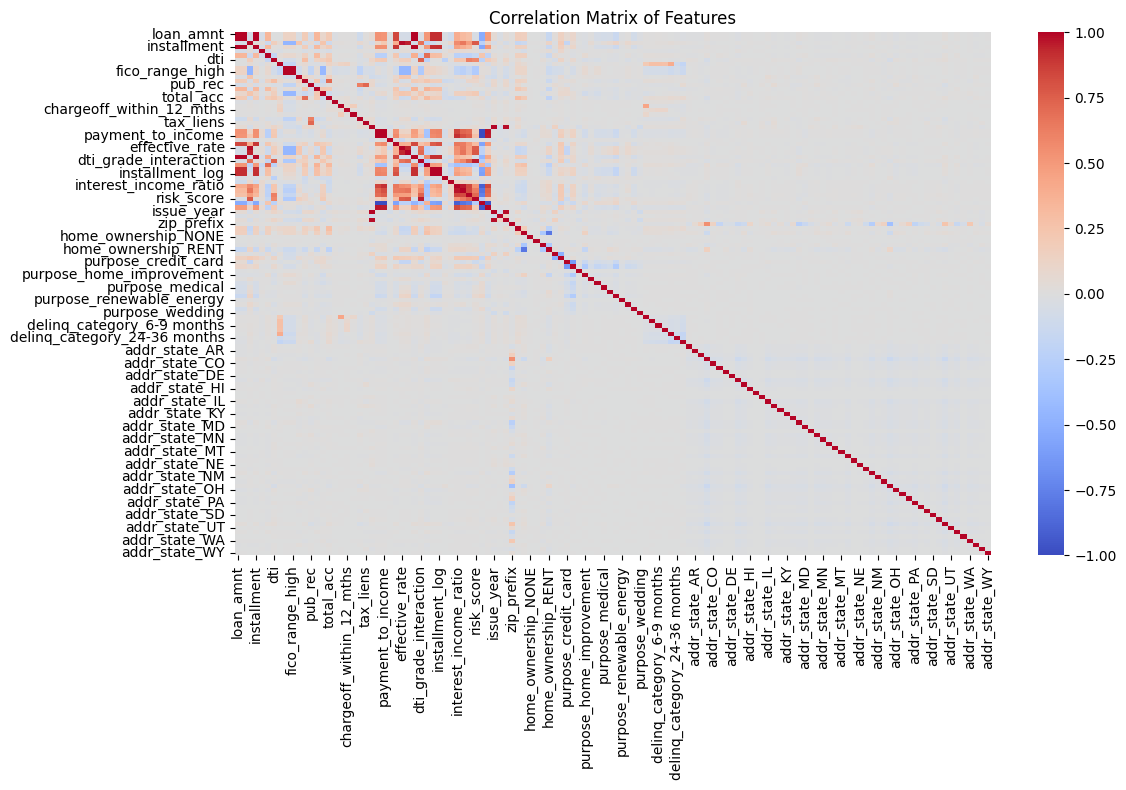


Top 10 correlations with target:
                     Feature  Correlation  Abs_Correlation
42                issue_year    -0.062975         0.062975
22                      year    -0.062975         0.062975
44  months_since_first_issue    -0.062540         0.062540
38         debt_burden_score    -0.049894         0.049894
37      payment_income_grade    -0.048727         0.048727
30     dti_grade_interaction    -0.047593         0.047593
39                risk_score    -0.045768         0.045768
36     interest_income_ratio    -0.041968         0.041968
6                        dti    -0.040077         0.040077
24         payment_to_income    -0.036570         0.036570


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nFeatures included:", X_train_scaled.columns.tolist())

correlation_matrix = X_train_scaled.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

correlations = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Correlation': [X_train_scaled[col].corr(y_train) for col in X_train_scaled.columns]
})
correlations['Abs_Correlation'] = abs(correlations['Correlation'])
correlations = correlations.sort_values('Abs_Correlation', ascending=False)

print("\nTop 10 correlations with target:")
print(correlations.head(10))

In [142]:
X_train = X_train_scaled
X_test = X_test_scaled

In [146]:
# import statsmodels.api as sm
# # Add constant for OLS
# X_train_ols = sm.add_constant(X_train)
# ols_model = sm.OLS(y_train, X_train_ols).fit()

# # Drop features with high p-values (> 0.05)
# significant_features = ols_model.pvalues[ols_model.pvalues < 0.05].index.tolist()
# if 'const' in significant_features:
#     significant_features.remove('const')



🔹 Training R² Score: 0.0162
🔹 Test R² Score: 0.0154

🔹 Mean Cross-Validation R²: 0.0158 (+/- 0.0016)


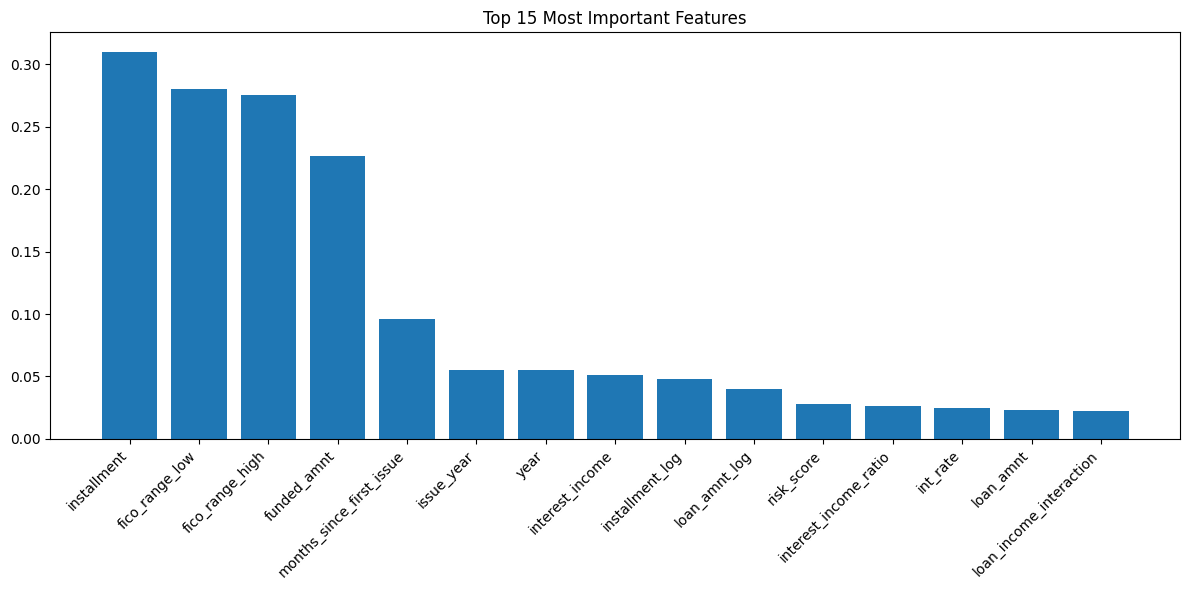


🔹 Top 15 Most Important Features:
                     Feature  Coefficient  Abs_Coefficient
3                installment    -0.310028         0.310028
8             fico_range_low     0.280482         0.280482
9            fico_range_high    -0.275365         0.275365
1                funded_amnt     0.226602         0.226602
44  months_since_first_issue     0.096344         0.096344
42                issue_year    -0.054864         0.054864
22                      year    -0.054864         0.054864
26           interest_income     0.050975         0.050975
33           installment_log    -0.048093         0.048093
32             loan_amnt_log     0.039857         0.039857
39                risk_score    -0.028104         0.028104
36     interest_income_ratio    -0.026661         0.026661
2                   int_rate     0.024665         0.024665
0                  loan_amnt     0.023416         0.023416
29   loan_income_interaction     0.022565         0.022565


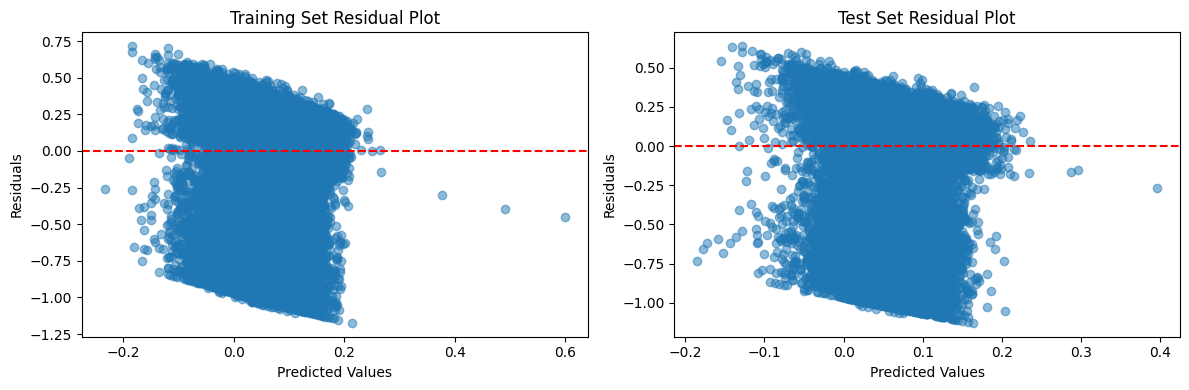

In [147]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n🔹 Training R² Score: {train_r2:.4f}")
print(f"🔹 Test R² Score: {test_r2:.4f}")

cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring="r2")
print(f"\n🔹 Mean Cross-Validation R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance.head(15))), feature_importance.head(15)['Abs_Coefficient'])
plt.xticks(range(len(feature_importance.head(15))), feature_importance.head(15)['Feature'], rotation=45, ha='right')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

print("\n🔹 Top 15 Most Important Features:")
print(feature_importance.head(15))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_pred_train, y_train - y_pred_train, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Training Set Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(122)
plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Test Set Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()


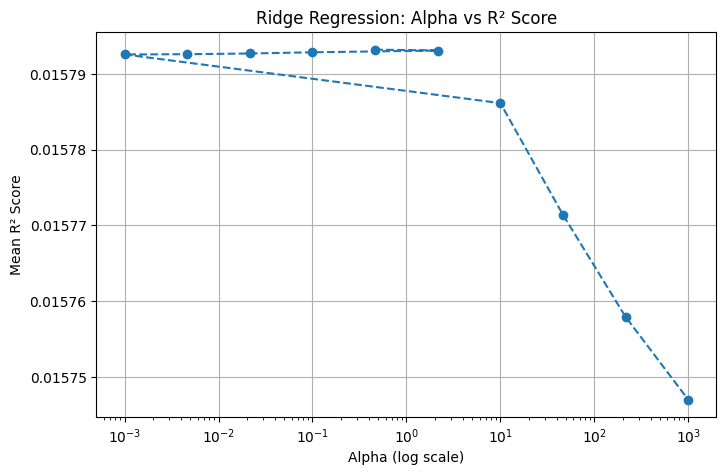

Best Alpha: 0.4642 | Best Mean R² Score: 0.0158


In [148]:
from sklearn.linear_model import Ridge
alpha_values = np.logspace(-3, 3, 10)  # Testing values from 0.001 to 1000

ridge_results = {}

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    
    cv_r2_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')
    mean_r2 = np.mean(cv_r2_scores)
    
    ridge_results[alpha] = mean_r2

ridge_results_df = pd.DataFrame(list(ridge_results.items()), columns=['Alpha', 'Mean R² Score'])
ridge_results_df.sort_values(by='Mean R² Score', ascending=False, inplace=True)

plt.figure(figsize=(8,5))
plt.plot(ridge_results_df['Alpha'], ridge_results_df['Mean R² Score'], marker='o', linestyle='--')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean R² Score')
plt.title('Ridge Regression: Alpha vs R² Score')
plt.grid(True)
plt.show()

best_alpha = ridge_results_df.iloc[0]
print(f"Best Alpha: {best_alpha['Alpha']:.4f} | Best Mean R² Score: {best_alpha['Mean R² Score']:.4f}")


In [ ]:
lr_ridge_model = Ridge(alpha=2.1544)
lr_ridge_model.fit(X_train, y_train)

y_pred_train = lr_ridge_model.predict(X_train)
y_pred_test = lr_ridge_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n🔹 Training R² Score: {train_r2:.4f}")
print(f"🔹 Test R² Score: {test_r2:.4f}")


🔹 Training R² Score: 0.0162
🔹 Test R² Score: 0.0154


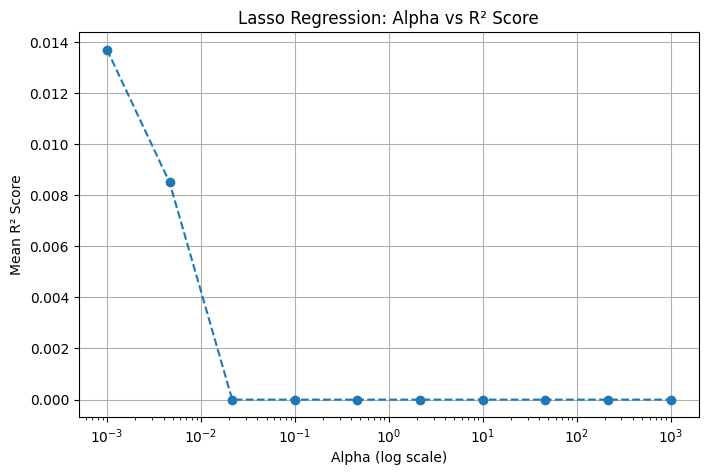

Best Alpha: 0.0010 | Best Mean R² Score: 0.0137


In [ ]:
from sklearn.linear_model import Lasso

alpha_values = np.logspace(-3, 3, 10)

lasso_results = {}

for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_model.fit(X_train, y_train)
    
    cv_r2_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='r2')
    mean_r2 = np.mean(cv_r2_scores)
    
    lasso_results[alpha] = mean_r2

lasso_results_df = pd.DataFrame(list(lasso_results.items()), columns=['Alpha', 'Mean R² Score'])
lasso_results_df.sort_values(by='Mean R² Score', ascending=False, inplace=True)

plt.figure(figsize=(8,5))
plt.plot(lasso_results_df['Alpha'], lasso_results_df['Mean R² Score'], marker='o', linestyle='--')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean R² Score')
plt.title('Lasso Regression: Alpha vs R² Score')
plt.grid(True)
plt.show()

best_alpha = lasso_results_df.iloc[0]
print(f"Best Alpha: {best_alpha['Alpha']:.4f} | Best Mean R² Score: {best_alpha['Mean R² Score']:.4f}")


In [ ]:
lr_lasso_model = Lasso(alpha=0.0010)
lr_lasso_model.fit(X_train, y_train)

y_pred_train = lr_lasso_model.predict(X_train)
y_pred_test = lr_lasso_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n🔹 Training R² Score: {train_r2:.4f}")
print(f"🔹 Test R² Score: {test_r2:.4f}")


🔹 Training R² Score: 0.0138
🔹 Test R² Score: 0.0136


In [ ]:
from sklearn.linear_model import ElasticNet

alpha_values = np.logspace(-3, 3, 10)
l1_ratios = [0.1, 0.5, 0.9]  # Mix of L1 and L2

elastic_results = {}

for alpha in alpha_values:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        model.fit(X_train, y_train)
        
        cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        mean_r2 = np.mean(cv_r2_scores)
        
        elastic_results[(alpha, l1_ratio)] = mean_r2

elastic_results_df = pd.DataFrame(list(elastic_results.items()), columns=['(Alpha, L1 Ratio)', 'Mean R² Score'])
elastic_results_df.sort_values(by='Mean R² Score', ascending=False, inplace=True)

best_alpha, best_l1_ratio = elastic_results_df.iloc[0]['(Alpha, L1 Ratio)']
best_r2 = elastic_results_df.iloc[0]['Mean R² Score']
print(f"Best Alpha: {best_alpha:.4f} | Best L1 Ratio: {best_l1_ratio:.2f} | Best Mean R² Score: {best_r2:.4f}")


Best Alpha: 0.0010 | Best L1 Ratio: 0.10 | Best Mean R² Score: 0.0157


In [ ]:
lr_elastic_model = ElasticNet(alpha=0.0010, l1_ratio=0.10)
lr_elastic_model.fit(X_train, y_train)

y_pred_train = lr_elastic_model.predict(X_train)
y_pred_test = lr_elastic_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n🔹 Training R² Score: {train_r2:.4f}")
print(f"🔹 Test R² Score: {test_r2:.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.536e+01, tolerance: 4.585e+00
  model = cd_fast.enet_coordinate_descent(



🔹 Training R² Score: 0.0160
🔹 Test R² Score: 0.0153


In [65]:
import pickle

with open("linear_model.pkl", "wb") as file:
    pickle.dump(lr_model, file)

print("Model saved successfully as linear_model.pkl")

with open("linear_ridge_model.pkl", "wb") as file:
    pickle.dump(lr_ridge_model, file)

print("Model saved successfully as linear_ridge_model.pkl")

with open("linear_lasso_model.pkl", "wb") as file:
    pickle.dump(lr_lasso_model, file)

print("Model saved successfully as linear_lasso_model.pkl")

with open("linear_elasticnet_model.pkl", "wb") as file:
    pickle.dump(lr_elastic_model, file)

print("Model saved successfully as linear_elasticnet_model.pkl")

Model saved successfully as linear_model.pkl
Model saved successfully as linear_ridge_model.pkl
Model saved successfully as linear_lasso_model.pkl
Model saved successfully as linear_elasticnet_model.pkl


In [154]:
new_test_data = pd.read_csv("Data/lc_loan_test_preprocessed2.csv")

In [155]:
id_column = new_test_data["id"]

new_test_data = new_test_data.drop(columns=["id"])

In [156]:
expected_features = lr_ridge_model.feature_names_in_

for feature in expected_features:
    if feature not in new_test_data.columns:
        new_test_data[feature] = 0  # Add missing columns with default value

new_test_data = new_test_data[expected_features]

In [157]:
new_lr_predict = lr_lasso_model.predict(new_test_data)
predict_lr_df = pd.DataFrame({"id": id_column, "predicted_value": new_lr_predict})
predict_lr_df.rename(columns={"predicted_value": "return"}, inplace=True)
predict_lr_df.to_csv("Data/lc_loan_test_results5.csv", index=False)